#### LoRA Fine-Tuning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import transformers
import os
import random
import h5py
import pandas as pd
import time
import importlib
from pprint import pprint
import torch 
from tqdm import tqdm
from utils.qwen import load_qwen
import re
import gc

device = 'cuda' if torch.cuda.is_available() else 'cpu' 
file_path = "data/lotka_volterra_data.h5"  # Change this to the correct path

c:\Users\Alik\Desktop\M_year\MPhil\Lent\DL\Coursework\am3353\m2-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import utils
importlib.reload(utils)
from utils.forecast import *
from utils.preprocess import ts_encoding, ts_decoding
from utils.lora import LoRALinear
from utils.preprocess import process_sequences
from utils.preprocess import ts_encoding, ts_decoding
from torch.utils.data import TensorDataset, DataLoader

In [3]:
import utils.lora
import utils.preprocess
importlib.reload(utils.lora)
importlib.reload(utils.preprocess)

from utils.lora import LoRALinear
from utils.preprocess import process_sequences
from utils.preprocess import ts_encoding, ts_decoding
from torch.utils.data import TensorDataset, DataLoader


# from torchsummary import summary

In [4]:
random_state = 28
np.random.seed(random_state)

In [5]:
manual_config = {
        'seq_length' : 512,
        'batch_size' : 2,
        'lora_rank' : 2,
        'hidden_layers' : 10,
        'model_size' : '0.5b',
        'training_steps' : 10000
}

train_split = 0.1
time_step_split = 0.8
batch_size = manual_config['batch_size']
learning_rate = 1e-5
lora_rank = manual_config['lora_rank']
max_ctx_length = 512
forecast_length = 21
max_tokens = manual_config['seq_length']

In [6]:
with h5py.File(file_path, "r") as f:
    # Print the dataset keys
    print("Keys in HDF5 file:", list(f.keys()))
    time_data, traj_data = f[list(f.keys())[0]][:], f[list(f.keys())[-1]][:]

Keys in HDF5 file: ['time', 'trajectories']


In [7]:
data_prey, data_pred = traj_data[:, :, 0], traj_data[:, :, -1]

data_prey, data_prey_true = data_prey[:, :int(time_step_split*data_prey.shape[-1])], data_prey[:, int(time_step_split*data_prey.shape[-1]) - 1:]
data_pred, data_pred_true = data_pred[:, :int(time_step_split*data_pred.shape[-1])], data_pred[:, int(time_step_split*data_pred.shape[-1]) - 1:]
time_data_past, time_data_true = time_data[:int(time_step_split*time_data.shape[0])], time_data[int(time_step_split*time_data.shape[0]) - 1:]

print(data_prey.shape, data_prey_true.shape, data_pred.shape, data_pred_true.shape)
print(time_data_past.shape, time_data_true.shape, data_prey.shape, data_pred.shape)

(1000, 80) (1000, 21) (1000, 80) (1000, 21)
(80,) (21,) (1000, 80) (1000, 80)


In [8]:
check_rn = random.randint(0, len(data_prey))

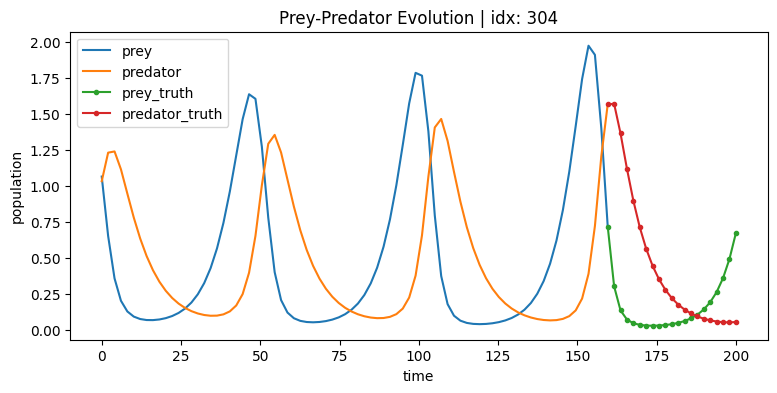

In [9]:
fig = plt.figure(figsize=(9, 4))

plt.plot(time_data_past, data_prey[check_rn], label = 'prey')
plt.plot(time_data_past, data_pred[check_rn], label = 'predator')

plt.plot(time_data_true, data_prey_true[check_rn], label = 'prey_truth', marker = '.')
plt.plot(time_data_true, data_pred_true[check_rn], label = 'predator_truth', marker = '.')

plt.xlabel('time')
plt.ylabel('population')

plt.legend()
plt.title(f'Prey-Predator Evolution | idx: {check_rn}')
plt.show()

In [10]:
ft = time.time()
model, tokenizer = load_qwen()
lt = time.time()

print('time-taken: ', (lt - ft)/60, 'mins') 

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


time-taken:  0.06544442971547444 mins


In [11]:
model.config.max_position_embeddings = manual_config['seq_length']
model.config.num_hidden_layers = manual_config['hidden_layers']

##### Dataset-Creation

In [12]:
encoded_prey, offset_prey, scale_prey = ts_encoding(data_prey, model_type="llama", precision=3, alpha=0.99, beta=0.3)
encoded_pred, offset_pred, scale_pred = ts_encoding(data_pred, model_type="llama", precision=3, alpha=0.99, beta=0.3)

In [13]:
prey_pred_encoded = []
for token_prey, token_pred in zip(encoded_prey, encoded_pred):
    prey_pred_encoded.append(create_forecast_prompt_joint(token_prey, token_pred, forecast_length=forecast_length))

prey_pred_encoded = np.array(prey_pred_encoded)
print(prey_pred_encoded.shape)

(1000,)


In [14]:
data_train, data_test = prey_pred_encoded[:int(train_split * len(prey_pred_encoded))], prey_pred_encoded[int(train_split * len(prey_pred_encoded)):]  
print(data_train.shape, data_test.shape)

(100,) (900,)


In [15]:
train_input_ids = process_sequences(data_train, tokenizer, max_ctx_length, stride=max_ctx_length // 2)
val_input_ids = process_sequences(data_test, tokenizer, max_ctx_length, stride=max_ctx_length)

train_dataset = TensorDataset(train_input_ids)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_input_ids)
val_loader = DataLoader(train_dataset, batch_size=batch_size)

In [16]:
for batch_t, batch_v in zip(train_loader, val_loader):
    print(batch_t[0].shape, batch_v[0].shape)
    break

torch.Size([2, 512]) torch.Size([2, 512])


##### LoRA pre-training (we low-rank train the query and value projection matrices - retrain the attention networks)

In [17]:
# Apply LoRA to the model:
### replacing attention layers with trainable layers (r * in_dim) + (out_dim * r)
for layer in model.model.layers:
    layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=manual_config['lora_rank']) 
    layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=manual_config['lora_rank'])

In [18]:
optimizer = torch.optim.Adam((p for p in model.parameters() if p.requires_grad), lr=learning_rate)

In [19]:
def get_model_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total, trainable = get_model_params(model)
print(f"Total Parameters: {total:,}")
print(f"Trainable Parameters: {trainable:,}") ## 100x lesser


Total Parameters: 494,319,872
Trainable Parameters: 287,104


##### Joint-Training

In [20]:
# # Prepare components with Accelerator
# accelerator = Accelerator()
# model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

model.train()

target_steps = 50
print('Target-Train-Steps: ', target_steps)

train_steps = 0
progress_bar = tqdm(range(target_steps), desc="Training Steps")

train_curve, val_curve = [], []

while train_steps < target_steps:
    for (batch,) in train_loader:
        optimizer.zero_grad()
        outputs = model(batch, labels=batch)
        loss = outputs.loss ### Loss-function = a model data member
        loss.backward()
        optimizer.step()
        
        train_curve.append(loss.detach()) ### stochastic loss every optimization-step
        
        train_steps += 1
        progress_bar.update(1)
        progress_bar.set_postfix(loss=loss.item())

        if train_steps >= target_steps: ## the train_steps stopping condition is inside the FOR loop --> so it's just the training step NOT epoch
            break
    
    # with model.no_grad():
    #     for (batch, ) in val_loader:
    #         val_op = model(batch, labels=batch)
    #         val_loss = val_op.loss
    #         val_curve.append(val_loss)

model.eval()

Target-Train-Steps:  50


Training Steps: 100%|██████████| 50/50 [12:37<00:00, 11.22s/it, loss=18.3]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): LoRALinear(
            (original_linear): Linear(in_features=896, out_features=896, bias=True)
          )
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): LoRALinear(
            (original_linear): Linear(in_features=896, out_features=128, bias=True)
          )
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm(

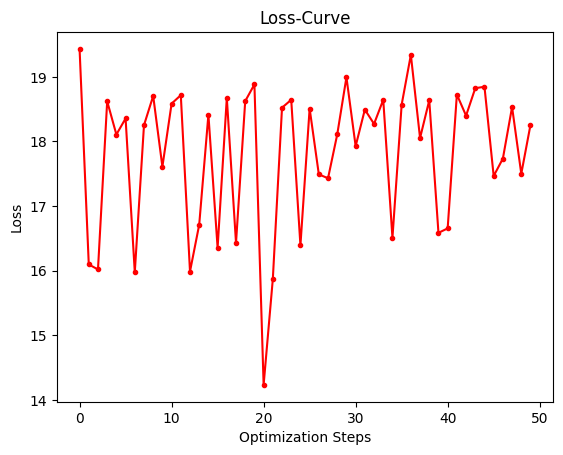

In [ ]:
plt.plot(range(len(train_curve)), train_curve, color = 'red', marker = '.', label = 'Train')
# plt.plot(range(len(val_curve)), val_curve, 'b', label = 'Validation')

plt.ylabel('Loss')
plt.xlabel('Optimization Steps')
plt.title('Loss-Curve')
plt.show()

In [22]:
ft = time.time()
torch.save(model, f"saves/model_{target_steps}_{train_split}.pth")
lt = time.time()

print('time-taken: ', (lt - ft)/60, ' mins')

time-taken:  0.3322938640912374  mins


##### Loading Model

In [23]:
model_list = os.listdir('saves')
path = os.path.join('saves', model_list[0])
print('Load-File: ', path)

model_lora = torch.load(path, weights_only=False)
model_lora.eval()

Load-File:  saves\model_50_0.1.pth


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): LoRALinear(
            (original_linear): Linear(in_features=896, out_features=896, bias=True)
          )
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): LoRALinear(
            (original_linear): Linear(in_features=896, out_features=128, bias=True)
          )
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm(

In [24]:
test_prompt = prey_pred_encoded[0]

In [ ]:
ft = time.time()
prey_pred_response = generate_forecast(model_lora, test_prompt, tokenizer, forecast_length=forecast_length, max_new_tokens=max_tokens)
lt = time.time()

print('time-taken: ', (lt - ft) / 60)

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (512). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


In [ ]:
print(type(prey_pred_response), len(prey_pred_response), repr(prey_pred_response))

In [ ]:
prey_decoded_response, pred_decoded_response = extract_forecasts(prey_pred_response)

print(len(prey_decoded_response), len(pred_decoded_response))
print(prey_decoded_response)

prey_decoded_response = ts_decoding(prey_decoded_response, model_type="llama", precision=3, offsets=offset_prey[check_rn], scale_factors=scale_prey[check_rn])[:forecast_length]
pred_decoded_response = ts_decoding(pred_decoded_response, model_type="llama", precision=3, offsets=offset_pred[check_rn], scale_factors=scale_pred[check_rn])[:forecast_length]

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

axs[0].plot(time_data_past, data_prey[check_rn].tolist(), label = 'Past Data')
axs[0].plot(time_data_true[:len(prey_decoded_response)], prey_decoded_response, label = 'Prediction', marker = '.')
axs[0].plot(time_data_true, data_prey_true[check_rn].tolist(), label = 'Truth', marker = '.')

axs[0].set_title('Prey-Population (Joint)')
axs[0].set_xlabel('time')
axs[0].legend()

axs[1].plot(time_data_past, data_pred[check_rn].tolist(), label = 'Past Data')
axs[1].plot(time_data_true[:len(prey_decoded_response)], pred_decoded_response, label = 'Prediction', marker = '.')
axs[1].plot(time_data_true, data_pred_true[check_rn].tolist(), label = 'Truth', marker = '.')

axs[1].set_title('Predator-Population (Joint)')
axs[1].set_xlabel('time')
axs[1].legend()

plt.show()


''' 
Jointly show them in the same plot 
'''
print()

plt.plot(time_data_past, data_prey[check_rn].tolist(), label = 'Past Data')
plt.plot(time_data_true, prey_decoded_response, label = 'Prediction', marker = '.')
plt.plot(time_data_true, data_prey_true[check_rn].tolist(), label = 'Truth', marker = '.')

plt.plot(time_data_past, data_pred[check_rn].tolist(), label = 'Past Data')
plt.plot(time_data_true, pred_decoded_response, label = 'Prediction', marker = '.')
plt.plot(time_data_true, data_pred_true[check_rn].tolist(), label = 'Truth', marker = '.')

plt.xlabel('time')
plt.title('Prey-Predator-Population (Joint)')
plt.legend()
plt.show()
